## Background :
 The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
df = pd.read_csv('/content/drive/My Drive/bank-full.csv')
df.head()

,"age;""job"";""marital"";""education"";""default"";""balance"";""housing"";""loan"";""contact"";""day"";""month"";""duration"";""campaign"";""pdays"";""previous"";""poutcome"";""y"""
0,"58;""management"";""married"";""tertiary"";""no"";2143..."
1,"44;""technician"";""single"";""secondary"";""no"";29;""..."
2,"33;""entrepreneur"";""married"";""secondary"";""no"";2..."
3,"47;""blue-collar"";""married"";""unknown"";""no"";1506..."
4,"33;""unknown"";""single"";""unknown"";""no"";1;""no"";""n..."


## Split Columns :




In [20]:
split_data = df['age;"job";"marital";"education";"default";"balance";"housing";"loan";"contact";"day";"month";"duration";"campaign";"pdays";"previous";"poutcome";"y"'].str.split(";")

data = split_data.to_list()

names = ["Age", 
         "Job", 
         "Marital-status", 
         "Education", 
         "Default", 
         "Balance", 
         "Housing", 
         "Loan", 
         "Contact", 
         "Day", 
         "Month", 
         "Duration", 
         "Campaign", 
         "Prev-days", 
         "Prev-contacts", 
         "Prev-outcome", 
         "y"]

df2 = pd.DataFrame(data, columns=names)
df2.head()

,Age,Job,Marital-status,Education,Default,Balance,Housing,Loan,Contact,Day,Month,Duration,Campaign,Prev-days,Prev-contacts,Prev-outcome,y
0,58,"""management""","""married""","""tertiary""","""no""",2143,"""yes""","""no""","""unknown""",5,"""may""",261,1,-1,0,"""unknown""","""no"""
1,44,"""technician""","""single""","""secondary""","""no""",29,"""yes""","""no""","""unknown""",5,"""may""",151,1,-1,0,"""unknown""","""no"""
2,33,"""entrepreneur""","""married""","""secondary""","""no""",2,"""yes""","""yes""","""unknown""",5,"""may""",76,1,-1,0,"""unknown""","""no"""
3,47,"""blue-collar""","""married""","""unknown""","""no""",1506,"""yes""","""no""","""unknown""",5,"""may""",92,1,-1,0,"""unknown""","""no"""
4,33,"""unknown""","""single""","""unknown""","""no""",1,"""no""","""no""","""unknown""",5,"""may""",198,1,-1,0,"""unknown""","""no"""


## Check for null values :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             45211 non-null  object
 1   Job             45211 non-null  object
 2   Marital-status  45211 non-null  object
 3   Education       45211 non-null  object
 4   Default         45211 non-null  object
 5   Balance         45211 non-null  object
 6   Housing         45211 non-null  object
 7   Loan            45211 non-null  object
 8   Contact         45211 non-null  object
 9   Day             45211 non-null  object
 10  Month           45211 non-null  object
 11  Duration        45211 non-null  object
 12  Campaign        45211 non-null  object
 13  Prev-days       45211 non-null  object
 14  Prev-contacts   45211 non-null  object
 15  Prev-outcome    45211 non-null  object
 16  y               45211 non-null  object
dtypes: object(17)
memory usage: 5.9+ MB


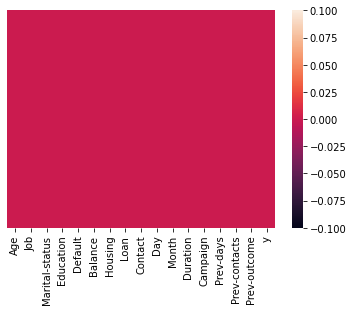

In [21]:
sn.heatmap(df2.isnull(), yticklabels=False)
df2.info()

## Encode Categorical Columns :

In [22]:
def convert_categorical(category, df):
    s = str(category)
    df = pd.get_dummies(df, columns=[s])
    return df

def encode_df(df):
    
    df_encoded = convert_categorical('Job', df)
    df_encoded = convert_categorical('Marital-status', df_encoded)
    df_encoded = convert_categorical('Education', df_encoded)
    df_encoded = convert_categorical('Default', df_encoded)
    df_encoded = convert_categorical('Housing', df_encoded)
    df_encoded = convert_categorical('Loan', df_encoded)
    df_encoded = convert_categorical('Contact', df_encoded)
    df_encoded = convert_categorical('Month', df_encoded)
    df_encoded = convert_categorical('y', df_encoded)
    df_encoded1 = convert_categorical('Prev-outcome', df_encoded)
  
    return(df_encoded1)

df_encoded = encode_df(df2)
df_encoded.head()

,Age,Balance,Day,Duration,Campaign,Prev-days,Prev-contacts,"Job_""admin.""","Job_""blue-collar""","Job_""entrepreneur""","Job_""housemaid""","Job_""management""","Job_""retired""","Job_""self-employed""","Job_""services""","Job_""student""","Job_""technician""","Job_""unemployed""","Job_""unknown""","Marital-status_""divorced""","Marital-status_""married""","Marital-status_""single""","Education_""primary""","Education_""secondary""","Education_""tertiary""","Education_""unknown""","Default_""no""","Default_""yes""","Housing_""no""","Housing_""yes""","Loan_""no""","Loan_""yes""","Contact_""cellular""","Contact_""telephone""","Contact_""unknown""","Month_""apr""","Month_""aug""","Month_""dec""","Month_""feb""","Month_""jan""","Month_""jul""","Month_""jun""","Month_""mar""","Month_""may""","Month_""nov""","Month_""oct""","Month_""sep""","y_""no""","y_""yes""","Prev-outcome_""failure""","Prev-outcome_""other""","Prev-outcome_""success""","Prev-outcome_""unknown"""
0,58,2143,5,261,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,47,1506,5,92,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1


## Convert all values to float :

In [23]:
 df1 = df_encoded.astype(float)

## Are the classes balanced?

The classes are :
* 0 => The person did not subscribe.
* 1 => The person subscribed to the term deposit.

In [24]:
 df1['y_"yes"'].value_counts()

0.0    39922
1.0     5289
Name: y_"yes", dtype: int64

## The classes are not balanced. 
Running the following cell will oversample the minority class.


In [25]:
max_size = df1['y_"yes"'].value_counts().max()
lst = [df1]
for class_index, group in df1.groupby('y_"yes"'):
    lst.append(group.sample(max_size-len(group), replace=True))
frame_new = pd.concat(lst)
df1=frame_new
df1['y_"yes"'].value_counts()

1.0    39922
0.0    39922
Name: y_"yes", dtype: int64

## Scale all values :

In [26]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df1), columns = df1.columns)

## Drop an unnecessary column :

In [27]:
df_scaled.drop(['y_"no"'], axis=1, inplace=True)

## Shuffle Columns :

In [28]:
df_shuffled=df_scaled.sample(frac=1)
print(len(df_shuffled))

79844


## Split the data into train, test and validation sets :

In [29]:
train = df_shuffled.iloc[:70000]
val = df_shuffled.iloc[70000:75000]
test = df_shuffled.iloc[75000:]

## Split the dataframes into features and labels :

In [30]:
X_train, y_train= train.drop('y_"yes"', axis=1), train['y_"yes"']
print(X_train.shape)

X_val, y_val = val.drop('y_"yes"', axis=1), val['y_"yes"']
print(X_val.shape)

X_test, y_test = test.drop('y_"yes"', axis=1), test['y_"yes"']

(70000, 51)
(5000, 51)


## Form batches of tensors :

In [38]:
f=500 # no. of batches

train_batch = np.array_split(X_train, f) 
label_batch = np.array_split(y_train, f) # 50 sections/batches

val_batch = np.array_split(X_val, f)
val_label_batch = np.array_split(y_val, f)

test_batch = np.array_split(X_test,f) 
test_label_batch  = np.array_split(y_test, f)


for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
    train_batch[i] = train_batch[i]
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)
    
for i in range(len(val_batch)):
    val_batch[i] = torch.from_numpy(val_batch[i].values).float()
for i in range(len(val_label_batch)):
    val_label_batch[i] = torch.from_numpy(val_label_batch[i].values).float().view(-1, 1)
    
    
for i in range(len(test_batch)):
    test_batch[i] = torch.from_numpy(test_batch[i].values).float()
for i in range(len(test_label_batch)):
    test_label_batch[i] = torch.from_numpy(test_label_batch[i].values).float().view(-1, 1)
    
print("Batch size:", len(train_batch[0]))

print(type(train_batch))

Batch size: 140
<class 'list'>


## Define the Neural Net :
The input layer contains 51 neurons, each corresponding to a single feature. The output layer has only one neuron.

In [42]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(51, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 1)
       
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x

model = Regressor()
model = model.to(device)

In [43]:
model.load_state_dict(torch.load("./model_9135.pt"))

<All keys matched successfully>

## Training parameters :

In [44]:
train_losses, val_losses = [], []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002) #0.005
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.5, patience=3) 
total_epochs=0

## The Training Loop :

In [49]:
epochs = 5
total_epochs+=epochs

for e in range(epochs):
    
    model.train()
    train_loss = 0
    val_loss_1=0
    val_loss_sum = 0
    
    for i in tnrange(len(train_batch)):
        
        optimizer.zero_grad()
        output = model(train_batch[i].to(device))
        
        loss = criterion(output, label_batch[i].to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
        with torch.no_grad():
            
            for j in range(len(val_batch)):
                
                val_output = model(val_batch[j].to(device))
                val_loss =  criterion(val_output, val_label_batch[j].to(device))
                val_loss_1+=val_loss.item()
        val_loss_sum=val_loss_1/len(val_batch)
        
        
    print("Epoch :", e, "train_loss :", train_loss/len(train_batch), "Val loss: ", val_loss_sum/len(val_batch))    
    val_losses.append(val_loss_sum/len(val_batch))    
    train_losses.append(train_loss/len(train_batch))   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch : 0 train_loss : 0.046563462486490605 Val loss:  0.05116628117492755


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch : 1 train_loss : 0.04455191386863589 Val loss:  0.05012071587791795


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch : 2 train_loss : 0.043514167847111825 Val loss:  0.049799257168856824


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch : 3 train_loss : 0.04254841639474034 Val loss:  0.049589111032121366


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch : 4 train_loss : 0.04169590022228658 Val loss:  0.0497046631627645


## How well does the model perform on the test-set?


In [51]:
correct=0
i=0
res=[]
with torch.no_grad():
    for batch in test_batch :
        for j in range(len(batch)):
            x = model(batch[j].to(device))
            #print(round(x.item()))
            res.append(round(x.item()))

true_labels= list(test['y_"yes"'])

for i in range(len(res)):
    if res[i]==int(true_labels[i]):
        correct+=1
        
print("Accuracy:", 100*(correct/len(res)), "%")

Accuracy: 94.50867052023122 %


## Training Metrics :

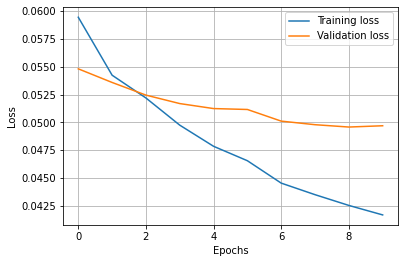

In [52]:
frm=0 # does not 
plt.plot(train_losses[frm:], label='Training loss')
plt.plot(val_losses[frm:], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

### Save Model :

In [53]:
torch.save(model.state_dict(), './model_945.pt')